<img src="images/chlalogo.jpg" width="500">

# Modelling Time Series Data with Theano

Electronic Health Records (EHRs) contain a wealth of patient medical information that can: save valuable time when an emergency arises; eliminate unnecesary treatment and tests; prevent potentially life-threatening mistakes; and, can improve the overall quality of care a patient receives when seeking medical assistance.  Children's Hospital Los Angeles (CHLA) wanted to know if the records could be mined to yield early warning signs of patients that may require extra care or an indication of the severity of a patient's illness.  In this lab we have access to the work and results of CHLA's applied use of deep neural networks on EHRs belonging to roughly 5,000 pediatric ICU patients.

We will use deep learning techniques to provide medical professionals an analytic framework to predict patient mortality at any time of interest. Such a solution provides essential feedback to clinicians when trying to assess the impact of treatment decisions or raise early warning signs to flag at risk patients in a busy hospital care setting.  

In this lab we will use the python library [```pandas```](http://pandas.pydata.org) to manage the dataset provided in [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) format and deep learning library [```Keras```](https://keras.io) to build recurrent neural networks ([RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network)).  In particular, this lab will construct a special kind of deep recurrent neural network that is called a long-short term memory network ([LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory)). Finally, we will compare the performance of this LSTM approach to standard mortality indices such as PIM2 and PRISM3 as well as contrast alternative solutions using more traditional machine learning methods like logistic regression.

## Process
We will go through the following steps in this lab to show you the work CHLA performed.  These steps are meant as an example of the steps that you may take when applying deep neural networks to your data.  As such, their steps do not represent an absolute or mechanical approach to using deep neural networks - every project will vary in approach.

1. Setup

   A. Configure Theano options

   B. Import Numpy, Pandas and Matplotlib

   C. Define folders which contain training / testing datasets

   D. Load data using Pandas API
<br>
<br>
2. Data preparation  

   A. Data review
   
   B. Data normalization

   C. Filling data gaps

   D. Data sequencing
<br>
<br>
3. Architect LSTM network using Keras and Theano
<br>
<br>
4. Build the model (feed data into network for training)
<br>
<br>
5. Evaluate model using validation (test) data
<br>
<br>
6. Visualize results
<br>
<br>
7. Compare baseline to PRISM3 and PIM2


## Getting Started
The first thing we do is import libraries into our Python workspace.  We import the usual suspects such as NumPy for numerical calculations, pandas for data management, Matplotlib for visualizations, and Keras for building LSTM networks.  More on these in a bit ...

In [10]:
# configure Theano options
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"

In [11]:
import numpy as np          
import pandas as pd              
import matplotlib.pyplot as plt  
import random

# configure notebook to display plots
%matplotlib inline

Next we define a folder which contains both training and testing datasets stored in HDF5 format. Using this folder we define file paths inputs (X) and their associated labels (y).  [HDF5](http://www.hdfgroup.org/) stands for hierarchical data format version number 5.  The HDF format is designed specifically to store and organize large amounts of scientific data and was originally designed by [National Center for Supercomputing Applications](https://en.wikipedia.org/wiki/National_Center_for_Supercomputing_Applications).  Common file extensions include ```.hdf```, ```.hdf5```, or simply ```.h5```.  The HDF format has become very popular and is well maintained.  As a result, HDF5 is a flexible and robust format having API support in most languages and library compatibilty with Windows, OS X and Linux. It is important to note that HDF is a binary format and hence lacks the human readable transparency of text based CSV files.  However, HDF file format is much faster in performance, efficient in storage size, and scales well from small proof of concept ideas to [very large operational projects](https://www.hdfgroup.org/eos_vignette/).

In [12]:
# set up user paths
data_dir = './data'

# training data inputs: x and targets: y
x_train_path = os.path.join(data_dir, 'X_train.hdf')
y_train_path = os.path.join(data_dir, 'y_train.hdf')

# validation data inputs: x and targest: y
x_valid_path = os.path.join(data_dir, 'X_test.hdf')
y_valid_path = os.path.join(data_dir, 'y_test.hdf')

Finally, we load the data using ```pandas``` API for reading in HDF files.  Python with pandas is used in a wide variety of academic and commercial domains, including Finance, Neuroscience, Economics, Statistics, Advertising, Web Analytics, and more. The pandas library is an open source, BSD-licensed project providing easy-to-use data structures and analysis tools for the Python programming language. The pandas library features a fast and efficient DataFrame object for data manipulation with integrated indexing as well as tools for reading and writing data between in-memory data structures and different formats such as CSV and text files, Microsoft Excel, SQL databases, and the fast HDF5 format. Check out the [pandas documentation](http://pandas.pydata.org) for more info.

In [13]:
X_train = pd.read_hdf(x_train_path)
y_train = pd.read_hdf(y_train_path)

X_valid = pd.read_hdf(x_valid_path)
y_valid = pd.read_hdf(y_valid_path)

### The Data

This electronic health records (EHR) database contains medical treatments and histories of patients collected over time. The EHRs used here consists of 10 years worth of patient data in the Pediatric Intensive Care Unit (PICU) at Children's Hospital Los Angeles, curated by the virtual PICU ([vPICU](http://vpicu.net)) team. This dataset contains 76,693 observations over 5,000 unique patient encounters.  

<img style="float: right;" src="images/ehr.svg" width="450" height="300">
This data is an irregular time series of measurements taken over the course of a patient's stay in the PICU. Time between measurements can vary from minutes to hours. A simplified diagram of the data can be seen on the right. Measurements include:

* **Statics** *(e.g. gender, age, weight)*
* **Vitals** *(e.g. heart rate, respiratory rate)*
* **Labs** *(e.g. glucose, creatinine)*
* **Interventions** *(e.g. intubation, O2)*
* **Drugs** *(e.g. dopamine, epinephrine)*

For a complete list, see [data/ehr_features.csv](data/ehr_features.csv)

One thing to note is that in addition to the non-uniform sampling, not all measurements were taken for all patients.

If we just have a look at the training data, it's clear that we have a collection of patient encounters with a set of variables observed at different times during each encounter.  But again, not all variables are measured at each epoch (row entry).

Finally, the label (y) for each patient encounter is the ultimate result of alive (1) or not alive (0). 

Let's take a look at the data.

In [14]:
X_train

ABG Base excess (mEq/L)  ABG FiO2  \
b'encounterID' b'absoluteTime'                                      
8              0.000000                             NaN       NaN   
               0.250000                             NaN       NaN   
               0.500000                             NaN       NaN   
               0.583333                             NaN       NaN   
               0.750000                             NaN       NaN   
               1.383333                             NaN       NaN   
               1.750000                             NaN       NaN   
               2.250000                             NaN       NaN   
               2.500000                             NaN       NaN   
               2.750000                             NaN       NaN   
               3.583333                             NaN       NaN   
               3.750000                             NaN       NaN   
               4.750000                             NaN       NaN   
               5.083333                             NaN       NaN   
               5.250000                             NaN       NaN   
               5.416667                             NaN       NaN   
               5.750000                             NaN       NaN   
               6.750000                             NaN       NaN   
               6.850000                             NaN       NaN   
               7.583333                             NaN       NaN   
               7.750000                             NaN       NaN   
               8.250000                             NaN       NaN   
               8.750000                             NaN       NaN   
               8.816667                             NaN       NaN   
               9.750000                             NaN       NaN   
               10.750000                            NaN       NaN   
               10.766666                            NaN       NaN   
               11.016666                            NaN       NaN   
               11.750000                            NaN       NaN   
               12.750000                            NaN       NaN   
...                                                 ...       ...   
16259          74.000000                            NaN       NaN   
               74.500000                            NaN       NaN   
               75.000000                            NaN       NaN   
               75.199997                            NaN       NaN   
               75.583336                            NaN       NaN   
               76.000000                            NaN       NaN   
               77.000000                            NaN       NaN   
               78.000000                            NaN       NaN   
               79.000000                            NaN       NaN   
               79.666664                            NaN       NaN   
               80.000000                            NaN       NaN   
               80.066666                            NaN       NaN   
               80.083336                            NaN       NaN   
               80.500000                            NaN       NaN   
               81.000000                            NaN       NaN   
               82.000000                            NaN       NaN   
               83.000000                            NaN       NaN   
               83.250000                            NaN       NaN   
               83.383331                            6.2       NaN   
               83.466667                            NaN       NaN   
               84.000000                            NaN       NaN   
               85.000000                            NaN       NaN   
               85.083336                            NaN       NaN   
               85.466667                            NaN       NaN   
               86.000000                            NaN       NaN   
               87.000000      

Notice here that there are 265 variables / columns in total.  We could also ask directly using ```len(X_train.columns)```.

NOTE: if you are uncertain about what type of object you are using, just ask for the ```type``` of the object.  In this case, ```X_train``` is a ```pandas``` dataframe object.  Read more about dataframes [here](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html). 

In [15]:
type(X_train)

pandas.core.frame.DataFrame

The data imported by pandas is a multi-index dataframe where index level 0 is the unique patient encounter identifier 
and index level 1 is the time of each measurement in units of hours since first measurement. To demonstrate how these dataframes are manipulated, we can select various encounters and extract specific variables, for example:

In [18]:
# first select a random patient counter (encounter identifier)
eIdx = random.choice(list(X_train.index.levels[0]))

# next specify a few variables to look at
variables = [
    'Age','Heart rate (bpm)','PulseOximetry','Weight',
    'SystolicBP','DiastolicBP','Respiratory rate (bpm)',
    'MotorResponse','Capillary refill rate (sec)'
]

# note that the full list of variables can be constructed using
#list(X_train.columns.values)

# have a look at the varibles for the patient
X_train.loc[eIdx, variables]

,Age,Heart rate (bpm),PulseOximetry,Weight,SystolicBP,DiastolicBP,Respiratory rate (bpm),MotorResponse,Capillary refill rate (sec)
b'absoluteTime',,,,,,,,,
0.000000,2.027912,127.0,100.0,9.0,100.0,85.0,25.0,NaN,NaN
0.150000,2.027930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.166667,2.027931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.233333,2.027939,116.0,100.0,NaN,105.0,12.0,20.0,NaN,NaN
0.483333,2.027967,99.0,100.0,NaN,NaN,NaN,19.0,NaN,NaN
0.566667,2.027977,96.0,100.0,NaN,73.0,56.0,17.0,NaN,NaN
0.733333,2.027996,102.0,99.0,NaN,118.0,67.0,23.0,NaN,NaN
1.233333,2.028053,84.0,100.0,NaN,98.0,39.0,30.0,6.0,4.0
1.483333,2.028082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, have a quick look at the label data for each patient encounter.

In [17]:
y_train

mortalityResponse
b'encounterID' b'absoluteTime'                   
8              0.000000                         1
               0.250000                         1
               0.500000                         1
               0.583333                         1
               0.750000                         1
               1.383333                         1
               1.750000                         1
               2.250000                         1
               2.500000                         1
               2.750000                         1
               3.583333                         1
               3.750000                         1
               4.750000                         1
               5.083333                         1
               5.250000                         1
               5.416667                         1
               5.750000                         1
               6.750000                         1
               6.850000                         1
               7.583333                         1
               7.750000                         1
               8.250000                         1
               8.750000                         1
               8.816667                         1
               9.750000                         1
               10.750000                        1
               10.766666                        1
               11.016666                        1
               11.750000                        1
               12.750000                        1
...                                           ...
16259          74.000000                        1
               74.500000                        1
               75.000000                        1
               75.199997                        1
               75.583336                        1
               76.000000                        1
               77.000000                        1
               78.000000                        1
               79.000000                        1
               79.666664                        1
               80.000000                        1
               80.066666                        1
               80.083336                        1
               80.500000                        1
               81.000000                        1
               82.000000                        1
               83.000000                        1
               83.250000                        1
               83.383331                        1
               83.466667                        1
               84.000000                        1
               85.000000                        1
               85.083336                        1
               85.466667                        1
               86.000000                        1
               87.000000                        1
               87.083336                        1
               87.666664                        1
               88.000000                        1
               89.000000                        1

[1113529 rows x 1 columns]

We can generate a unique list of patient encounter IDs by asking the DataFrame for ```level[0]```.  

In [19]:
eIdx = X_train.index.levels[0];

Next iterate over each encounter to figure out number of observations.

In [20]:
nobs = [X_train.loc[ix].index.shape[0] for ix in eIdx]

Then make a histogram showing number of observations per encounter.

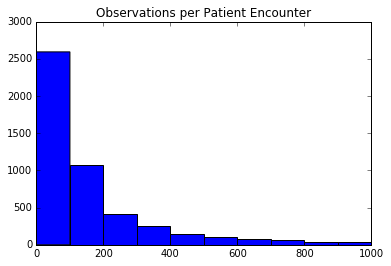

In [21]:
plt.hist(nobs,range=(0,1000))
plt.title("Observations per Patient Encounter")
plt.show()

Note that the mean number of observations per encounter, (given by ```np.mean(nobs)```), is 223 and the median count is 94.

Can we do a similar analysis to determine the observation timespan over all patient encounters?

In [ ]:
# Try here if you'd like

Finally, to get a look at a variable for a particular patient encounter simply extract that variable from an encounter and plot it using the ```pandas``` plot function.

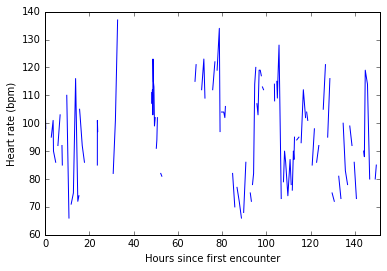

In [23]:
X_train.loc[8, "Heart rate (bpm)"].plot()
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Hours since first encounter")
plt.show()

Now that we've loaded and visualized the data, we'll prepare it to train our model.

### Data Normalization
We normalize each observed feature / variable by subtracting its mean and dividing the result by the standard deviation.  

Why?

We want small variations in one variable to be treated with the same emphasis as HUGE variations of another. Keep in mind that the network just sees a bunch of numbers - it doesn't actually "know" anything about predictors, factors, variables, obervations and so on and so forth. Emperically, normalization seems to facilitate training but this kind of normalization is probably not appropriate for multimodal data (or non-Gaussian data in general).

Let's find the distribution of these variables:

In [26]:
# create file path for csv file with metadata about variables
metadata = os.path.join(data_dir, 'ehr_features.csv')

# read in variables from csv file (using pandas) since each varable there is tagged with a category
variables = pd.read_csv(metadata, index_col=0)

# next, select only variables of a particular category for normalization
normvars = variables[variables['type'].isin(['Interventions', 'Labs', 'Vitals'])]

# finally, iterate over each variable in both training and validation data
for vId, dat in normvars.iterrows():
    
    X_train[vId] = X_train[vId] - dat['mean']
    X_valid[vId] = X_valid[vId] - dat['mean']
    X_train[vId] = X_train[vId] / (dat['std'] + 1e-12)
    X_valid[vId] = X_valid[vId] / (dat['std'] + 1e-12)
    

### Filling Data Gaps
Finally, having normalized the data we still need to fill in all the data gaps since not every variable was observed at each epoch of the patient encounter.  Filling in the gaps of missing data is a very active area of research and there is currently no standard practice for time series analysis using deep learning.  For this tutorial, we will simply forward fill existing measurements for each patient, and fill any variable entries with no previous measurement to 0 as illustrated below.

<img src="images/imputation_diagram.svg" width="800" height="200">

In [25]:
# first select variables which will be filled in
fillvars = variables[variables['type'].isin(['Vitals', 'Labs'])].index

# next forward fill any missing values with more recently observed value
X_train[fillvars] = X_train.groupby(level=0)[fillvars].ffill()
X_valid[fillvars] = X_valid.groupby(level=0)[fillvars].ffill()

# finally, fill in any still missing values with 0 (i.e. values that could not be filled forward)
X_train.fillna(value=0, inplace=True)
X_valid.fillna(value=0, inplace=True)

Quickly, lets have a look at the "Heart rate" variable after data normalization and missing values have been filled in.

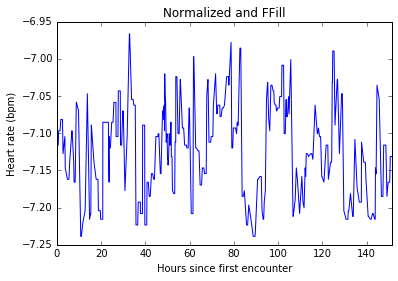

In [27]:
X_train.loc[8, "Heart rate (bpm)"].plot()
plt.title("Normalized and FFill")
plt.ylabel("Heart rate (bpm)")
plt.xlabel("Hours since first encounter")
plt.show()

Also, try dumping the X_train vector to the screen again and you will see that all those NaN values have been filled in with zeros.

In [28]:
X_train

ABG Base excess (mEq/L)  ABG FiO2  \
b'encounterID' b'absoluteTime'                                      
8              0.000000                        0.276032 -3.732888   
               0.250000                        0.276032 -3.732888   
               0.500000                        0.276032 -3.732888   
               0.583333                        0.276032 -3.732888   
               0.750000                        0.276032 -3.732888   
               1.383333                        0.276032 -3.732888   
               1.750000                        0.276032 -3.732888   
               2.250000                        0.276032 -3.732888   
               2.500000                        0.276032 -3.732888   
               2.750000                        0.276032 -3.732888   
               3.583333                        0.276032 -3.732888   
               3.750000                        0.276032 -3.732888   
               4.750000                        0.276032 -3.732888   
               5.083333                        0.276032 -3.732888   
               5.250000                        0.276032 -3.732888   
               5.416667                        0.276032 -3.732888   
               5.750000                        0.276032 -3.732888   
               6.750000                        0.276032 -3.732888   
               6.850000                        0.276032 -3.732888   
               7.583333                        0.276032 -3.732888   
               7.750000                        0.276032 -3.732888   
               8.250000                        0.276032 -3.732888   
               8.750000                        0.276032 -3.732888   
               8.816667                        0.276032 -3.732888   
               9.750000                        0.276032 -3.732888   
               10.750000                       0.276032 -3.732888   
               10.766666                       0.276032 -3.732888   
               11.016666                       0.276032 -3.732888   
               11.750000                       0.276032 -3.732888   
               12.750000                       0.276032 -3.732888   
...                                                 ...       ...   
16259          74.000000                       0.786799 -3.898335   
               74.500000                       0.786799 -3.898335   
               75.000000                       0.786799 -3.898335   
               75.199997                       0.786799 -3.898335   
               75.583336                       0.786799 -3.898335   
               76.000000                       0.786799 -3.898335   
               77.000000                       0.786799 -3.898335   
               78.000000                       0.786799 -3.898335   
               79.000000                       0.786799 -3.898335   
               79.666664                       0.786799 -3.898335   
               80.000000                       0.786799 -3.898335   
               80.066666                       0.786799 -3.898335   
               80.083336                       0.786799 -3.898335   
               80.500000                       0.786799 -3.898335   
               81.000000                       0.786799 -3.898335   
               82.000000                       0.786799 -3.898335   
               83.000000                       0.786799 -3.898335   
               83.250000                       0.786799 -3.898335   
               83.383331                       1.051492 -3.898335   
               83.466667                       1.051492 -3.898335   
               84.000000                       1.051492 -3.898335   
               85.000000                       1.051492 -3.898335   
               85.083336                       1.051492 -3.898335   
               85.466667                       1.051492 -3.898335   
               86.000000                       1.051492 -3.898335   
               87.000000      

### Data Sequencing
The final data preparation task is to pad every patient encounter so that all encounters have the same number of observations. Note from the histogram that there are many encounters with less than 100 observation vectors. Therefore we are going to zero pad each encounter (i.e. insert rows of zeros).

In [29]:
import keras
from keras.preprocessing import sequence

# max number of sequence length
maxlen = 500

# get a list of unique patient encounter IDs
teId = X_train.index.levels[0]
veId = X_valid.index.levels[0]

# pad every patient sequence with 0s to be the same length, 
# then transforms the list of sequences to one numpy array
# this is for efficient minibatching and GPU computations 
X_train = [X_train.loc[patient].values for patient in teId]
y_train = [y_train.loc[patient].values for patient in teId]

X_train = sequence.pad_sequences(X_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_train = sequence.pad_sequences(y_train, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

# repeat for the validation data

X_valid = [X_valid.loc[patient].values for patient in veId]
y_valid = [y_valid.loc[patient].values for patient in veId]

X_valid = sequence.pad_sequences(X_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')
y_valid = sequence.pad_sequences(y_valid, dtype='float32', maxlen=maxlen, padding='post', truncating='post')

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python3.4/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Okay, a lot just happened here:  

1. We converted the ```pandas``` data frame into a Python ```list``` which contained lists of values (a list of list of values).  
2. Using  ```keras.preprocessing.sequence.pad_sequences``` we converted the value lists into a ```numpy.array``` of type ```float32``` having a maximum length of 500.  
3. If the patient encounter didn't have 500 encounters (most don't, see previous histogram) then we apply ```padding='post'``` which says to pad with zeros.  That is add extra rows (observation vectors) of all zeros.
4. The option ```truncating='post'``` just says if there are more than 500 observations then take the first 500 and drop everything after.  

Together, this says: *force patient encounter records of dimension 500x265 and use zero padding to inflate the size if needed*.  We could do something similar in ```pandas``` but not with only a single command.

In [30]:
# print the shape of the array which will be used by the network
# the shape is of the form (# of encounters, length of sequence, # of features)
print("X_train shape: %s | y_train shape: %s" % (str(X_train.shape), str(y_train.shape)))
print("X_valid shape: %s | y_valid shape: %s" % (str(X_valid.shape), str(y_valid.shape)))

X_train shape: (5000, 500, 265) | y_train shape: (5000, 500, 1)
X_valid shape: (2690, 500, 265) | y_valid shape: (2690, 500, 1)


Note that the type of X_train has changed to ```numpy.ndarray```:

In [32]:
type(X_train)

numpy.ndarray

Now we can plot the full patient encounter as a matrix plot.  Try a few times to get a feel for what the charts look like.

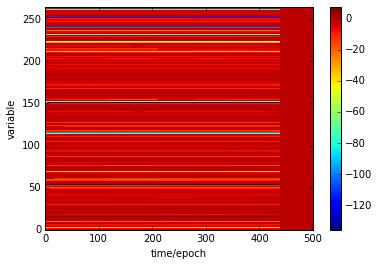

In [34]:
# figure out how many encounters we have
numencnt = X_train.shape[0]

# choose a random patient encounter to plot
ix = 0 #Try a few different index values between 0 and 4999

# plot a matrix of observation values
plt.pcolor(np.transpose(X_train[ix,:,:]))
plt.ylabel("variable")
plt.xlabel("time/epoch")
plt.ylim(0,265)
plt.colorbar()
plt.show()

Keep in mind here that these data are zero padded by ```sequence.pad_sequences```.  Try a few different index values between 0 and 4999 to get a feel for what the matrix plots look like. These matricies are what will be fed as input into the LSTM model for training. Notice that we can plot a variable in a similar fashion by selecting along the third axis instead of the first axis. This provides a view of a particular variable over all patient encounters. Give it a try!

## Recurrent Neural Network Models

The recurrent neural network ([RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network)) is effectively a traditional feed-forward network with feedback.  In a traditional feed-forward network all inputs are considered independent.  However, the input to an RNNs also includes the previous output state.  This allows RNNs to model very complex sequences of input and it can be shown that RNNs are, in fact, [Turing complete](https://en.wikipedia.org/wiki/Turing_completeness) (see [here](http://binds.cs.umass.edu/papers/1995_Siegelmann_Science.pdf)).
<img src="images/rnn.jpg" width="500">
<p style="text-align: center;">*image credit: wildml.com*</p>

In theory RNNs can make use of information in arbitrarily long sequences, but in practice they are limited to looking back only a few steps due to what is called the [*vanishing gradient*](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) problem.  In essence, during the traning process, as errors are backpropagated through time, inputs from previous time steps get exponentially down weighted and are eventually driven to zero (i.e. vanish).  

There is a variant of the RNN called the [Long Short Term Memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) network published by [Hochreiter & Schmidhuber](http://www.bioinf.jku.at/publications/older/2604.pdf) in 1997. LSTMs do not have vanishing gradient problems.  LSTM is normally augmented by recurrent gates called [forget gates](http://www.jmlr.org/papers/volume3/gers02a/gers02a.pdf). As mentioned, a defining feature of the LSTM is that it prevents backpropagated errors from vanishing (or exploding) and instead allow errors to flow backwards through unlimited numbers of "virtual layers" unfolded in time. That is, the LSTM can learn "[very deep](https://arxiv.org/abs/1404.7828)" tasks that require memories of events that happened thousands or even millions of discrete time steps ago. Problem-specific LSTM-like topologies can be [evolved](http://link.springer.com/chapter/10.1007/978-3-642-04277-5_76) and can work even when signals contain long delays or have a mix of low and high frequency components.

We will now construct a RNN in order to ingest the data and make a prediction at each timestep of the patient's probability of survival. The image below shows an abstract representation of the model to be constructed using ```Keras```.

<img src="images/drted_rnn.svg" width="800">

At each time step the measurements recorded will be used as input and a probability of survival prediction will be generated. It is important to note that this enables a real time monitor of the patient's probability of survival and insight into the patient's trajectory.

### Constructing LSTM Network with Keras
[Keras](https://keras.io) is a minimalist but modular neural networks library written in Python.   ```Keras``` is capable of running on top of either the [TensorFlow](https://www.tensorflow.org) or [Theano](http://deeplearning.net/software/theano/) frameworks.  Here we are interested in using Theano as it excels at RNNs in general and LSTM in particular.  Note that some frameworks such as [Caffe](http://caffe.berkeleyvision.org) do not support RNNs.  Keras was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.  The ```Keras``` library allows for easy and fast prototyping of solutions and supports both convolutional networks and recurrent networks, as well as combinations of the two.  Furthermore, ```Keras``` supports arbitrary connectivity schemes (including multi-input and multi-output training).
Finally, ```Keras``` runs on either CPU or GPU and is compatible with Python 2.7-3.5.

In [35]:
from keras.layers import LSTM, Dense, Input, TimeDistributed, Masking
from keras.models import Model
from keras.optimizers import RMSprop

# Note: building model using Keras Functional API (version > 1.0)

# construct inputs
x = Input((None, X_train.shape[-1]) , name='input')
mask = Masking(0, name='input_masked')(x)

# stack LSTMs
lstm_kwargs = {'dropout_W': 0.25, 'dropout_U': 0.1, 'return_sequences': True, 'consume_less': 'gpu'}
lstm1 = LSTM(128, name='lstm1', **lstm_kwargs)(mask)

# output: sigmoid layer
output = TimeDistributed(Dense(1, activation='sigmoid'), name='output')(lstm1)
model = Model(input=x, output=output)

# compile model
optimizer = RMSprop(lr=0.005)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# print layer shapes and model parameters
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, None, 265)     0                                            
____________________________________________________________________________________________________
input_masked (Masking)           (None, None, 265)     0           input[0][0]                      
____________________________________________________________________________________________________
lstm1 (LSTM)                     (None, None, 128)     201728      input_masked[0][0]               
____________________________________________________________________________________________________
output (TimeDistributed)         (None, None, 1)       129         lstm1[0][0]                      
Total params: 201857
______________________________________________________________________

### Decisions made while architecting the model

We created a single LSTM.
 
*Binary cross entropy loss function* is used because it is the theoretically optimal cost function for a binary classification problem (in this case, mortality). However, occasionally the Mean Squared Error (MSE) cost function is used since it tends to be a bit more stable numerically.
 
*Dropout W* is used because it randomly drops elements of the input vector (It drops the same elements of the vector for every time step of the sequence). This forces the network to leverage information contained in potentially covariate variables (for instance – for a particular sample Heart Rate may be ‘dropped’, but a combination of systolic/diastolic blood pressure and breathing rate may provide a reasonable proxy).
 
*Dropout U* is used for similar reasons to traditional dropout in CNNs. It forces the network to utilize all of the hidden nodes such that too much information is not contained in a single hidden unit. In practice this tends to lead to more stable networks.
 
*RMSprop* optimizer is selected because it is a good general optimizer for LSTMs.  See [here](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) for more details.  
 
*LR=0.005* is selected in order to find a reasonable local minimum within a small number of epochs for time consideration.  Typically one would likely use an even smaller LR and allow the network to take smaller ‘learning steps’ but that choice requires more training rounds to converge (i.e. slower training).
 
As always with neural networks, there was some amount of hyper-parameter tuning.  It is important to keep in mind that this network has not been optimally tuned.  A handful of reasonable default values were chosen to create a state-of-the-art mortality predictor in the least amount of GPU cycles possible (for tutorial purposes).

Read the [docs](https://keras.io/layers/core/) for more information on core layers in ```Keras```. 

Now, lets feed some data into the network for training. We use a batch size of 128 which means that we update parameters every 128 images.  For demonstration purposes we will use only 5 training epochs, which means that we run through the data 5 times.  Finally, the verbose option just says to produce status / summary information during the training.

In [39]:
X_train.shape

(5000, 500, 265)

In [63]:
# this will take a while...
#import numpy as np
#for tmp in range(100):
#    np.random.seed(tmp)
#    print (tmp,model.train_on_batch(X_train[1:1000],y_train[1:1000]))
np.random.seed(89)
history = model.fit(X_train, y_train, batch_size=128, nb_epoch=5, verbose=1)

Epoch 1/5
5000/5000 [==============================] - 19s - loss: 0.2448    
Epoch 2/5
5000/5000 [==============================] - 18s - loss: 0.2454    
Epoch 3/5
5000/5000 [==============================] - 18s - loss: 0.2538    
Epoch 4/5
5000/5000 [==============================] - 18s - loss: 0.2516    
Epoch 5/5
5000/5000 [==============================] - 18s - loss: 0.2485    


### Evaluate Model & Compare with Baselines

Our first task in evaluating the model performance is to predict mortality using the hold out dataset (i.e. validation data).

In [ ]:
# generate RNN results on holdout validation set
preds = model.predict(X_valid)

Notice that size of the predictions.

In [ ]:
preds.shape

That is, we have 2,690 patient encounters for testing, and at each of the observations the model predicts survivability.  Lets plot some predictions!

In [ ]:
# figure out how many encounters we have
numencnt = X_valid.shape[0]

# choose a random patient encounter to plot
ix = random.randint(0,numencnt-1)

# create axis side by side
f, (ax1, ax2) = plt.subplots(2, 1)

# plot the obs chart for patient encounter
ax1.pcolor(np.transpose(X_valid[ix,1:50,:]))
ax1.set_ylim(0,265)

# plot the patient survivability prediction
ax2.plot(preds[ix,1:50]);

## Comparison against baselines: PRISM3 and PIM2.

Both PIM2 and PRISM3 are scoring systems for ICU and surgical patients.  Models that predict the risk of death of groups of patients admitted to intensive care are available for adult, pediatric and neonatal intensive care. By adjusting for differences in severity of illness and diagnosis, these models can be used to compare the standard of care between units and within units over time. They can also be used to compare different methods of organising intensive care. Estimating mortality risk is also an important component of comparing groups of patients in research trials.  

The Pediatric Index of Mortality (PIM) was originally developed as a simple model that requires variables collected at the time of admission to intensive care. The original PIM was developed predominantly in Australian units; in the first report only one of the eight units was actually available in the United Kingdom. The PIM2 is a revised mortality index using a more recent data set from 14 intensive care units, eight in Australia, four in the UK, and two in New Zealand. In the analysis for PIM2, 20,787 patient admissions of children less than 16 years of age were included. Since PIM2 estimates mortality risk from data readily available at the time of ICU admission it is therefore suitable for continuous monitoring of the quality of paediatric intensive care. PIM2 uses the first value of each variable measured within the period from the time of first contact to one hour after arrival in the ICU.  If information is missing (e.g. Base Excess is not measured) PIM2 records zero, except for systolic blood pressure, which should be recorded as 120. All consecutive admissions are included.  See [Slater et al.](https://www.ncbi.nlm.nih.gov/pubmed/12541154) for full details.

Similarly, the Pediatric Risk of Mortality ([PRISM](http://www.ncbi.nlm.nih.gov/pubmed/3048900)) score was originally developed around 1988 from the Physiologic Stability Index ([PSI](http://www.ncbi.nlm.nih.gov/pubmed/6728571)) to reduce the number of variables required for pediatric ICU mortality risk assessment, from 34 (in the PSI) to 14 and to obtain an objective weighting of the remaining variables.  Here <a href="http://www.jpeds.com/article/S0022-3476(97)70065-9/abstract">PRISM3</a> is an updated version of the scoring system published in 1996 which has several improvements over the original model. However, it is only available under licence and is not widely used outside of the United States.  The PRISM3 score has 17 physiologic variables subdivided into 26 ranges. The variables determined most predictive of mortality were minimum systolic blood pressure, abnormal pupillary reflexes, and stupor/coma.

First, we'd compute [ROC](gim.unmc.edu/dxtests/roc2.htm) information for the predictions.

In [ ]:
from sklearn.metrics import roc_curve, auc

# get 0/1 binary lable for each patient encounter
label = y_valid[:, 0, :].squeeze();

# get the last prediction in [0,1] for the patient
prediction = preds[:, -1, :].squeeze()

# compute ROC curve for predictions
rnn_roc = roc_curve(label,prediction)

# compute the area under the curve of prediction ROC
rnn_auc = auc(rnn_roc[0], rnn_roc[1])

Next we'd extract precompute PIM2 and PRISM3 estimates from CSV file.

In [ ]:
# scores for baselines PRISM3 and PIM2 were aggregated and stored in `data/pim2prism3.csv`.
# load the scores and then compute the ROC curves and AUC
index = pd.read_csv(os.path.join(data_dir, 'pim2prism3.csv'))

# get the mortality reponse for each patient
mortrep = index['mortalityResponse'];

# generate ROC curves for each index
pim2_roc   = roc_curve(mortrep, -index['PIM2'  ])
prism3_roc = roc_curve(mortrep, -index['PRISM3'])

# compute the area under the curve for each index
pim2_auc   = auc(  pim2_roc[0],   pim2_roc[1])
prism3_auc = auc(prism3_roc[0], prism3_roc[1])

Let's now plot these ROC curves against our RNN for comparison.

In [ ]:
# plot rocs & display AUCs
plt.figure(figsize=(7, 5))
line_kwargs = {'linewidth': 4, 'alpha': 0.8}
plt.plot(prism3_roc[0], prism3_roc[1], label='prism3: %0.3f' % prism3_auc, color='#4A86E8', **line_kwargs)
plt.plot(pim2_roc[0], pim2_roc[1], label='pim2: %0.3f' % pim2_auc, color='#FF9900', **line_kwargs)
plt.plot(rnn_roc[0], rnn_roc[1], label='rnn: %0.3f' % rnn_auc, color='#6AA84F', **line_kwargs)
plt.legend(loc='lower right', fontsize=20)
plt.xlim((-0.05, 1.05))
plt.ylim((-0.05, 1.05))
plt.xticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.yticks([0, 0.25, 0.5, 0.75, 1.0], fontsize=14)
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("Severity of Illness ROC Curves", fontsize=24)
plt.grid(alpha=0.25)
plt.tight_layout()

Notice how good this is considering we only did a few rounds of training!

## Conclusions
RNNs provide a method to quickly extract clinically significant information and insights from available EHR data.

The amount of data, model complexity, number of features, and number of epochs have been reduced in this tutorial to  reduce computational burden.  The examples below display the performance of a fully trained RNN on a larger dataset.  They also show the performance of PIM2 and PRISM3, two standard scoring systems,  as well as the performance of a logistic regression model and a multi-layer perceptron (MLP).  

The temporally dynamic nature of the RNN enables it to extract more information from the underlying EHR than an MLP.  The MLP's complexity is similar to the RNN's, but the former is limited to instantaneous information.

<img src="images/RNN_performance.svg" width="500" height="500">

Below shows the temporal trajectory of the fully trained RNN's probability of survival predictions. The capability to provide a prediction at any timestep of interest provides valuable feedback to a clinician working to asses the impact of treatment decisions.   

<img src="images/MortalityThroughTime.svg" width="500" height="500">


## Discovery Requires Experimentation
Here are a few ideas for how to 'turn knobs' and 'push buttons'.  How do these modifications effect training and performance w.r.t PIM2 and PRISM3?
1. Go and add a second and third LSTM layer to the network.  
2. Change the number of layers and the number of neurons in those layers.
3. How about changing some of the meta parameters in the network configuration like dropout or learning rate etc.?
4. [Homework] How about trying a CNN?  That is, does the RNN / LSTM model out perform a vanilla CNN model?
5. [Something to think about] Does this dataset suffer from too few negative / fatality cases?  ICU survivability is 96%.  How might this affect training?
